In [41]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg

In [47]:
def detect_fire_clusters(image_path, eps=20, min_samples=10, wind_weight=0.5):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Could not read the image")
    
    # Convert to grayscale and Gaussian blur to enhance wind lines
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Canny edge detection to extract wind lines
    edges = cv2.Canny(blurred, 100, 200)
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define range for red color (fire points)
    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])
    
    # Create masks for red regions
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = mask1 + mask2
    
    # Find coordinates of fire points
    fire_points = np.column_stack(np.where(mask > 0))
    
    if len(fire_points) == 0:
        raise ValueError("No fire points detected")
    
    # Cluster the fire points, now explicitly incorporating wind line information
    fire_points_with_wind = []
    for pt in fire_points:
        try:
            # Normalize coordinates and wind intensity
            x, y = pt
            wind_intensity = edges[y, x] / 255.0  # Normalize to 0-1
            
            # Weighted features: spatial coordinates and wind intensity
            weighted_pt = [
                x, 
                y, 
                wind_intensity * wind_weight  # Scale wind intensity 
            ]
            fire_points_with_wind.append(weighted_pt)
        except IndexError:
            continue
    
    fire_points_with_wind = np.array(fire_points_with_wind)
    
    if len(fire_points_with_wind) == 0:
        raise ValueError("No fire points with valid wind information")
    
    # Use DBSCAN with custom metric incorporating wind information
    clustering = DBSCAN(
        eps=eps, 
        min_samples=min_samples, 
        metric='euclidean'
    ).fit(fire_points_with_wind)
    
    # Get unique clusters (excluding noise points)
    unique_labels = set(clustering.labels_)
    unique_labels.discard(-1)  # Remove noise label
    n_clusters = len(unique_labels)
    
    # Create figure with three subplots for verification
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    
    # Plot original image with clusters
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Fire Clusters', fontsize=12, fontweight='bold')
    
    # Prepare for storing scatter objects and labels for a compact legend
    scatter_handles = []
    scatter_labels = []
    
    # Plot clusters with different colors and annotate hotspot counts
    colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters+1))
    for i, label in enumerate(unique_labels):
        cluster_points = fire_points_with_wind[clustering.labels_ == label, :2]
        hotspot_count = len(cluster_points)
        
        # Scatter plot of cluster points
        scatter = ax1.scatter(
            cluster_points[:, 1], 
            cluster_points[:, 0], 
            color=colors[i], 
            alpha=0.6, 
            s=50
        )
        
        # Store scatter handle and label for compact legend
        scatter_handles.append(scatter)
        scatter_labels.append(f'C{i+1}: {hotspot_count} hotspots')
        
        # Find cluster centroid for annotation
        if len(cluster_points) > 0:
            centroid_x = int(np.mean(cluster_points[:, 1]))
            centroid_y = int(np.mean(cluster_points[:, 0]))
            
            # Annotate hotspot count on the plot
            ax1.annotate(
                f'{hotspot_count}', 
                (centroid_x, centroid_y), 
                color='white', 
                fontweight='bold', 
                ha='center', 
                va='center',
                bbox=dict(facecolor='black', alpha=0.5, edgecolor='none')
            )
    
    # Add cluster count to title
    ax1.set_title(f'Fire Clusters (Count: {n_clusters})', 
                  fontsize=12, fontweight='bold')
    
    # Create a compact legend outside the plot area
    fig.legend(
        scatter_handles, 
        scatter_labels, 
        title='Clusters', 
        loc='center left', 
        bbox_to_anchor=(1, 0.5),
        fontsize=8
    )
    
    # Plot mask for verification
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Fire Detection Mask', fontsize=12, fontweight='bold')
    
    # Plot wind lines
    ax3.imshow(edges, cmap='gray')
    ax3.set_title('Wind Lines', fontsize=12, fontweight='bold')
    
    # Compute cluster statistics
    cluster_sizes = [np.sum(clustering.labels_ == label) for label in unique_labels]
    
    # Add overall statistics to the plot
    plt.suptitle(
        f'Fire Cluster Analysis\n'
        f'Clusters: {n_clusters} | '
        f'Total Fire Points: {len(fire_points)} | '
        f'Avg Cluster Size: {np.mean(cluster_sizes):.1f}', 
        fontsize=14, fontweight='bold'
    )
    
    # Remove axes for cleaner visualization
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    
    # Adjust layout to make room for the legend
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    
    # Save the figure to a file instead of showing it
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    img_buf = canvas.tostring_rgb()
    img_arr = np.frombuffer(img_buf, dtype=np.uint8)
    img_arr = img_arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return {
        'total_clusters': n_clusters,
        'cluster_sizes': cluster_sizes,
        'total_fire_points': len(fire_points),
        'visualization': img_arr,
        'mask': mask,
        'wind_lines': edges,
        'labeled_clusters': clustering.labels_
    }

# Rest of the code remains the same

In [48]:
def verify_overlay(result):
    """
    Print verification statistics about the clustering
    """
    print(f"Verification Results:")
    print(f"- Total number of clusters: {result['total_clusters']}")
    print(f"- Total fire points detected: {result['total_fire_points']}")
    print(f"- Cluster sizes: {result['cluster_sizes']}")
    print(f"- Average cluster size: {np.mean(result['cluster_sizes']):.1f}")
    print(f"- Largest cluster size: {max(result['cluster_sizes'])}")
    print(f"- Smallest cluster size: {min(result['cluster_sizes'])}")



/tmp/ipykernel_20621/4077171579.py:161: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_buf = canvas.tostring_rgb()


Verification Results:
- Total number of clusters: 71
- Total fire points detected: 45744
- Cluster sizes: [np.int64(45), np.int64(37), np.int64(90), np.int64(244), np.int64(36), np.int64(72), np.int64(19051), np.int64(86), np.int64(125), np.int64(43), np.int64(680), np.int64(39), np.int64(41), np.int64(43), np.int64(510), np.int64(54), np.int64(44), np.int64(44), np.int64(42), np.int64(106), np.int64(44), np.int64(426), np.int64(54), np.int64(40), np.int64(341), np.int64(39), np.int64(77), np.int64(281), np.int64(145), np.int64(81), np.int64(37), np.int64(39), np.int64(87), np.int64(10433), np.int64(37), np.int64(79), np.int64(42), np.int64(58), np.int64(77), np.int64(1861), np.int64(192), np.int64(34), np.int64(3243), np.int64(38), np.int64(41), np.int64(357), np.int64(12), np.int64(43), np.int64(38), np.int64(79), np.int64(683), np.int64(56), np.int64(33), np.int64(1742), np.int64(82), np.int64(71), np.int64(37), np.int64(57), np.int64(174), np.int64(118), np.int64(153), np.int64(18)

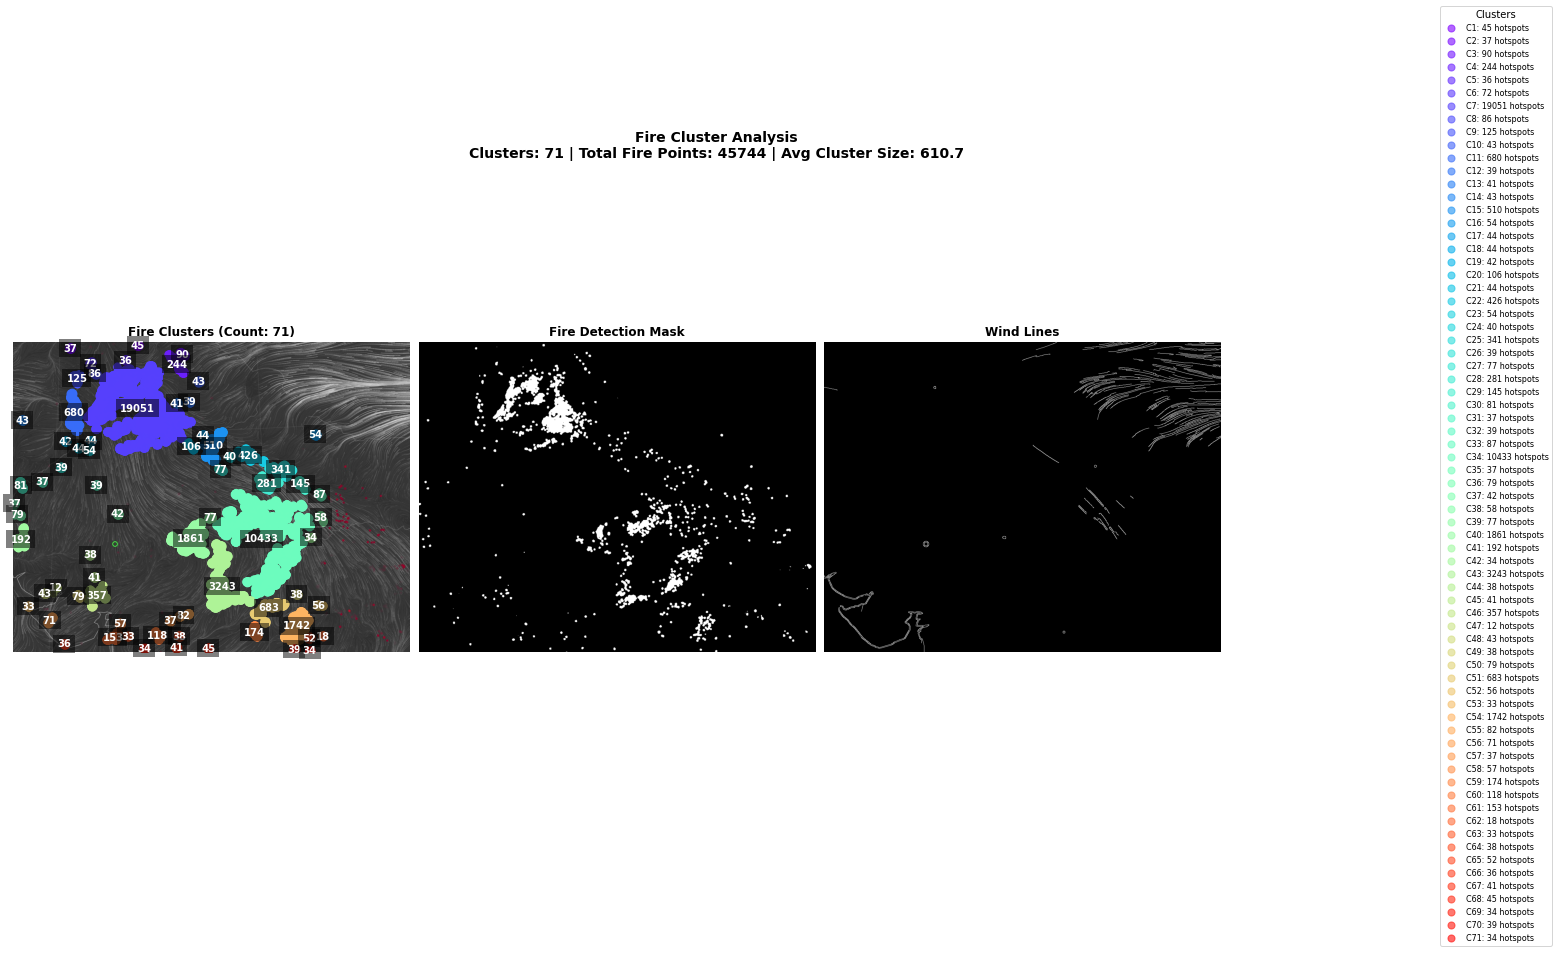

In [49]:
# Example usage
result = detect_fire_clusters('fire_points_northern_india_plain.jpg')
verify_overlay(result)
#plt.imshow(result['visualization'])
plt.show()